In [1]:
import os
import time
import torch
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import cv2 as cv

from pathlib import Path
from PIL import Image
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split

from src.data import blend
# from src.models import PretrainedUNet
from src.metrics import jaccard, dice


from src.mobilenet_v2 import MobileNetV2
from src.unet_mobilenet import UNetMobileNet

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [217]:
data_folder = Path("data")
models_folder = Path("models")
images_folder = Path("images")
data_description = pd.read_csv(data_folder / "train.csv")

In [4]:
splits = {}
splits["train"], splits["test"] = train_test_split(data_description, test_size=0.2, random_state=42)
splits["train"], splits["val"] = train_test_split(splits["train"], test_size=0.1, random_state=42)

splits["train"] = splits["train"].reset_index(drop=True)
splits["test"] = splits["test"].reset_index(drop=True)
splits["val"] = splits["val"].reset_index(drop=True)

In [69]:
class HumanSegmentDataset(torch.utils.data.Dataset):
    def __init__(self, description, data_folder, transfrom=None):
        self.description = description
        self.data_folder = data_folder
        self.transfrom = transfrom
        
        
    def __getitem__(self, idx):
        try:
            origin_fn = self.data_folder / self.description.loc[idx, "origin"]
            mask_fn = self.data_folder / self.description.loc[idx, "mask"]

            origin = Image.open(origin_fn)
            if origin.mode != "RGB":
                origin = origin.convert("RGB")

            mask = Image.open(mask_fn)

            if self.transfrom is not None:
                transformed = self.transfrom(
                    image=np.array(origin),
                    mask=np.array(mask)
                )
                origin = transformed["image"]
                mask = transformed["mask"]

            origin = torchvision.transforms.functional.to_tensor(origin) - 0.5
            mask = (torchvision.transforms.functional.to_tensor(mask) > 0).float()

            return origin, mask
        except Exception as e:
            
            print(f"current idx: {idx}", e)
            return torch.zeros((3, 256, 256)), torch.zeros((1, 256, 256))
        
    def __len__(self):
        return len(self.description)

In [70]:
batch_size = 16

train_transforms = A.Compose([
    A.ShiftScaleRotate(scale_limit=0.02, rotate_limit=0, border_mode=0, value=0),
    A.Resize(256, 256),
    A.HorizontalFlip(),
])

test_val_transforms = A.Compose([
    A.Resize(256, 256),
])


datasets = {mode: HumanSegmentDataset(
    splits[mode],
    data_folder,
    train_transforms if mode == "train" else test_val_transforms
) for mode in ["train", "test", "val"]}

dataloaders = {x: torch.utils.data.DataLoader(
    datasets[x], 
    batch_size=batch_size
) for x in ["train", "test", "val"]}

loading time: 0.006663084030151367


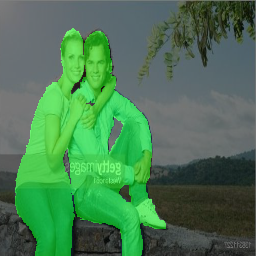

In [68]:
start_t = time.time()

# image, mask = datasets["train"][67783]
image, mask = datasets["train"][63]


end_t = time.time()
print(f"loading time: {end_t - start_t}")

blend(image+0.5, mask[0])

In [10]:
mobile_unet = UNetMobileNet(num_classes=1, mobilenet_weights_path="models/mobilenet_v2.pth.tar")
mobile_unet.to(device)

In [14]:
optimizer = torch.optim.Adam(mobile_unet.parameters(), lr=0.0005)

In [15]:
train_log_filename = "hs-mobile-train-log.txt"
epochs = 18
best_val_loss = np.inf
model_name = "hs-mobile-unet-v0.pt"

In [ ]:
hist = []

for e in range(epochs):
    start_t = time.time()
    
    mobile_unet.train()
    train_loss = 0.0
    pbar_desc = f"epoch: {e+1}/{epochs}, train phase"
    
    for origins, masks in tqdm(dataloaders["train"], desc=pbar_desc, position=0, leave=True):
        
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        

        outs = mobile_unet(origins)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(outs, masks)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * num
        
    train_loss = train_loss / len(datasets['train'])
    
    
    mobile_unet.eval()
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0
    pbar_desc = f"epoch: {e+1}/{epochs}, validation phase"
        
    for origins, masks in tqdm(dataloaders["val"], desc=pbar_desc, position=0, leave=True):
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            outs = mobile_unet(origins)
            val_loss = torch.nn.functional.binary_cross_entropy_with_logits(outs, masks)
            
            outs = (outs > 0).float()

            val_jaccard += jaccard(masks, outs).item() * num
            val_dice += dice(masks, outs).item() * num

    val_loss = val_loss / len(datasets["val"])
    val_jaccard = val_jaccard / len(datasets["val"])
    val_dice = val_dice / len(datasets["val"])
    
    
    end_t = time.time()
    spended_t = end_t - start_t
    
    with open(train_log_filename, "a") as train_log_file:
        report = f"epoch: {e+1}/{epochs}, time: {spended_t}, train loss: {train_loss}, \n"\
               + f"val loss: {val_loss}, val jaccard: {val_jaccard}, val dice: {val_dice}"

        hist.append({
            "time": spended_t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_jaccard": val_jaccard,
            "val_dice": val_dice,
        })

        print(report)
        train_log_file.write(report + "\n")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(mobile_unet.state_dict(), models_folder / model_name)
            print("model saved")
            train_log_file.write("model saved\n")
        print()
        

epoch: 1/18, train phase:   0%|          | 0/4237 [00:00<?, ?it/s]/home/devel/Documents/ucu/.local/lib/python3.6/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
epoch: 1/18, train phase:  42%|████▏     | 1775/4237 [16:44<22:54,  1.79it/s]/home/devel/Documents/ucu/.local/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
epoch: 1/18, train phase:  53%|█████▎    | 2239/4237 [21:07<19:02,  1.75it/s]

current idx: 35831 tuple index out of range


epoch: 1/18, train phase:  56%|█████▌    | 2358/4237 [22:44<26:58,  1.16it/s]

current idx: 37735 local variable 'photoshop' referenced before assignment


epoch: 1/18, train phase:  62%|██████▏   | 2627/4237 [26:35<22:42,  1.18it/s]

epochs: 18, overall time: 765.0m, mean epoch time: 2553.0322485102547s


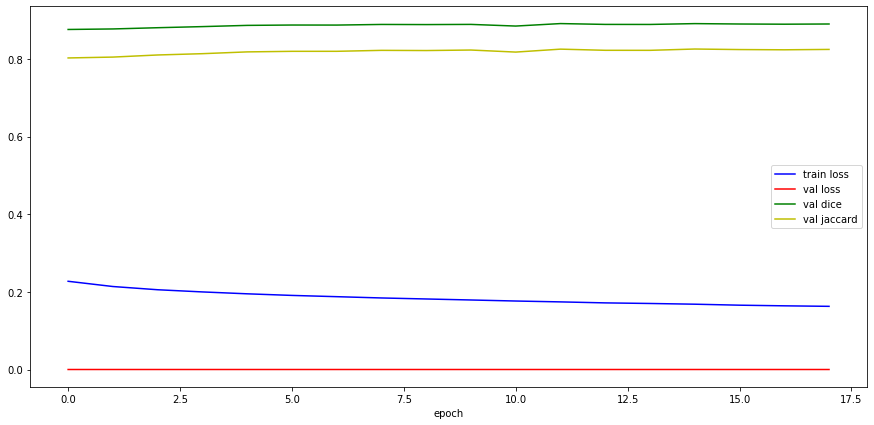

In [218]:
plt.figure(figsize=(15,7))
train_loss_hist = [h["train_loss"] for h in hist]
plt.plot(range(len(hist)), train_loss_hist, "b", label="train loss")

val_loss_hist = [h["val_loss"] for h in hist]
plt.plot(range(len(hist)), val_loss_hist, "r", label="val loss")

val_dice_hist = [h["val_dice"] for h in hist]
plt.plot(range(len(hist)), val_dice_hist, "g", label="val dice")

val_jaccard_hist = [h["val_jaccard"] for h in hist]
plt.plot(range(len(hist)), val_jaccard_hist, "y", label="val jaccard")

plt.legend()
plt.xlabel("epoch")
plt.savefig(images_folder / model_name.replace(".pt", "-train-hist.png"))

time_hist = [h["time"] for h in hist]
overall_time = sum(time_hist) // 60
mean_epoch_time = sum(time_hist) / len(hist)
print(f"epochs: {len(hist)}, overall time: {overall_time}m, mean epoch time: {mean_epoch_time}s")

In [212]:
hist

[{'time': 3226.5171041488647,
  'train_loss': 0.22725582567920627,
  'val_loss': tensor(4.8113e-05, device='cuda:0'),
  'val_jaccard': 0.8024216559549879,
  'val_dice': 0.875771723335497},
 {'time': 2515.2593252658844,
  'train_loss': 0.21376144546242937,
  'val_loss': tensor(4.3498e-05, device='cuda:0'),
  'val_jaccard': 0.8046484956131043,
  'val_dice': 0.877108724333793},
 {'time': 2514.6331996917725,
  'train_loss': 0.2054547927222876,
  'val_loss': tensor(4.6329e-05, device='cuda:0'),
  'val_jaccard': 0.81007656497773,
  'val_dice': 0.8802911401491372},
 {'time': 2513.0598249435425,
  'train_loss': 0.19983696745514912,
  'val_loss': tensor(4.3243e-05, device='cuda:0'),
  'val_jaccard': 0.8134166691699563,
  'val_dice': 0.8831341314746292},
 {'time': 2511.908944129944,
  'train_loss': 0.19497096890276527,
  'val_loss': tensor(4.3431e-05, device='cuda:0'),
  'val_jaccard': 0.8180185228158867,
  'val_dice': 0.8862918903393373},
 {'time': 2513.3681519031525,
  'train_loss': 0.19085109

In [ ]:
idx = 22
threshold = 0.5

origin, mask = datasets["test"][idx]

origin = torch.stack([origin])
mask = torch.stack([mask])

origin = origin.to(device)
mask = mask.to(device)

out = mobile_unet(origin)

out = torch.sigmoid(out)

out = (out > threshold)

blend(origin.cpu()[0]+0.5, out.cpu()[0][0])